In [20]:
import numpy as np
from scipy.io import loadmat
from scipy.stats import chi2_contingency
from scipy.spatial import KDTree
import os
from collections import Counter
import pandas as pd
import time
from matplotlib import pyplot as plt
import shutil

download_data_readpath = 'E:/Dataset/wind_shear/Data_Download'
exception_data_readpath = '../Dataset/Exception_Data'
result_savepath = '../result'

# 读取download_path目录下的所有文件夹
download_folder_names = [item for item in os.listdir(download_data_readpath) if os.path.isdir(os.path.join(download_data_readpath,item))]

# 读取exception_data_path目录下的所有文件夹
file_names = os.listdir(exception_data_readpath)
folder_names = [item for item in file_names if os.path.isdir(os.path.join(exception_data_readpath, item))]

# 参数设置
K = 16 # K-means++ param
internal_segment_quantiles = [0.25, 0.5, 0.75]

In [40]:
# 检测所有mat的变量列表似然度
variable_list_excel_savepath = os.path.join(result_savepath, 'variable_list')
if os.path.exists(variable_list_excel_savepath) == False:
    os.mkdir(variable_list_excel_savepath)

variable_lists2D = []
variable_list_counter = Counter()

# 对所有mat文件的变量列表进行类型计数
for folder_name in folder_names:
    data_folder = os.path.join(exception_data_readpath, folder_name)
    mat_names = os.listdir(data_folder)
    variable_lists = []
    for mat_name in mat_names:
        mat_path = os.path.join(data_folder, mat_name)
        mat_data = loadmat(mat_path)
        # print(list(mat_data.keys()))
        variable_lists.append(list(mat_data.keys()))
        variable_list_counter.update([tuple(variable_lists[-1])])
    variable_lists2D.append(variable_lists)
    # break
# variable_matrix = np.array(variable_lists2D)

varList_type_id = 0
for variables, count in variable_list_counter.items():
    # print(f"{variables}: {count}")
    print("Variable number in current type is: %d"%len(list(variables)))

    # 由于每个文件夹中mat文件数目不一致，生成的三维数组并不是矩阵，会出现AttributeError: 'bool' object has no attribute 'all'
    '''match_ids = np.where((variable_matrix == list(variables)).all(axis=2))
    # print(len(match_ids[0]))
    first_match_id = [match_ids[0][0], match_ids[1][0]]
    print(first_match_id)'''
    
    # 找到第一个与类型变量列表相符的mat文件，并将其description输出
    first_match_id = []
    for row in variable_lists2D:
        match_ids = np.where((np.array(row) == list(variables)).all(axis=1))
        # print(len(match_ids))
        if match_ids[0].size != 0:
            first_match_id = [variable_lists2D.index(row), match_ids[0][0]]
            print("Adopt the first match id " + str(first_match_id) + " as variable description source")
            break

    data_folder = os.path.join(exception_data_readpath, folder_names[first_match_id[0]])
    mat_names = os.listdir(data_folder)
    mat_data = loadmat(os.path.join(data_folder, mat_names[first_match_id[1]]))
    variables_description = []
    for key, value in mat_data.items():
        # print(value)
        if key.startswith("__") and key.endswith("__"):
            variables_description.append('NA')
            continue
        variables_description.append(value["Description"][0][0][0])

    # 将当前变量列表类型导出为excel
    excel_matrix = np.array([list(variables), variables_description]).T
    excel_df = pd.DataFrame(excel_matrix, columns=['variable', 'description'])
    excel_df.to_excel(os.path.join(variable_list_excel_savepath, "type_%d.xlsx"%varList_type_id), index=False)

    varList_type_id += 1


Variable number in current type is: 189
Adopt the first match id [0, 0] as variable description source


In [ ]:
# 变量类型筛选（静态/动态）并打印动态变量

folder_name = folder_names[0]
data_folder = os.path.join(exception_data_readpath, folder_name)
mat_names = os.listdir(data_folder)
mat_path = os.path.join(data_folder, mat_names[0])
variable_figure_savepath = os.path.join(variable_list_excel_savepath, "variable plots")
if os.path.exists(variable_figure_savepath) == False:
    os.mkdir(variable_figure_savepath)

static_variables = []
dynamic_variables = []
for variable, content in mat_data.items():
    if variable.startswith("__") and variable.endswith("__"):
        continue
    # print(content)
    variable_data = content['data'][0][0]
    # print(variable_data.shape)
    if np.var(variable_data) == 0:
        static_variables.append(variable)
    else:
        dynamic_variables.append(variable)
        plt.figure()
        plt.plot(variable_data)
        plt.xlabel(variable)
        plt.ylabel("value")
        plt.title(variable)
        plt.savefig(os.path.join(variable_figure_savepath, variable + ".png"))
    # break

print(dynamic_variables)
print(len(dynamic_variables))

In [11]:
print(len(folder_names))

309


In [17]:
# 对原始数据集进行卡方检验
K_square_savepath = os.path.join(result_savepath, "K_square")
if os.path.exists(K_square_savepath) == False:
    os.mkdir(K_square_savepath)

folder_mat_total_num_list = []
folder_mat_exception_num_list = []
for folder_name in download_folder_names:
    download_folder = os.path.join(download_data_readpath, folder_name)
    folder_mat_total_num_list.append(len(os.listdir(download_folder)))
    data_folder = os.path.join(exception_data_readpath, folder_name)
    if os.path.exists(data_folder) == False:
        folder_mat_exception_num_list.append(0)
    else:
        folder_mat_exception_num_list.append(len(os.listdir(data_folder)))

# 执行卡方检验
K_square_test_array = np.vstack([folder_mat_exception_num_list, folder_mat_total_num_list])
# print(K_square_test_array.shape)
np.save(os.path.join(K_square_savepath, 'downdoad_data_test_array'), K_square_test_array)
chi2, p, dof, expected = chi2_contingency(K_square_test_array)
print("卡方值：", chi2)
print("p值：", p)
print("自由度：", dof)
# print("期望值：", expected)


卡方值： 564.3259685341824
p值： 3.5586166218294715e-17
自由度： 309


In [ ]:
# 按照航程(DWPT)的长度对mat文件进行分类

# 读取全部DWPT信息
'''
理论上它们应当是一个从总里程递减至0的数据
但实际数据中基本不会发生变化
但由于采样率恒定为1
因此将DWPT数据的列表总长作为航程长度的代表数据
'''
dwpt_list_savepath = os.path.join(result_savepath, 'dwpt_list')
if os.path.exists(dwpt_list_savepath) == False:
    os.mkdir(dwpt_list_savepath)

dwpt_lists = []
for folder_name in folder_names:
    data_folder = os.path.join(exception_data_readpath, folder_name)
    mat_names = os.listdir(data_folder)
    dwpt_list = []
    for mat_name in mat_names:
        mat_path = os.path.join(data_folder, mat_name)
        mat_data = loadmat(mat_path)
        dwpt_list.append(mat_data["DWPT"][0][0][0])
    dwpt_lists.append(dwpt_list)
np.save(os.path.join(dwpt_list_savepath, 'dwpt_lists.npy'), dwpt_lists)


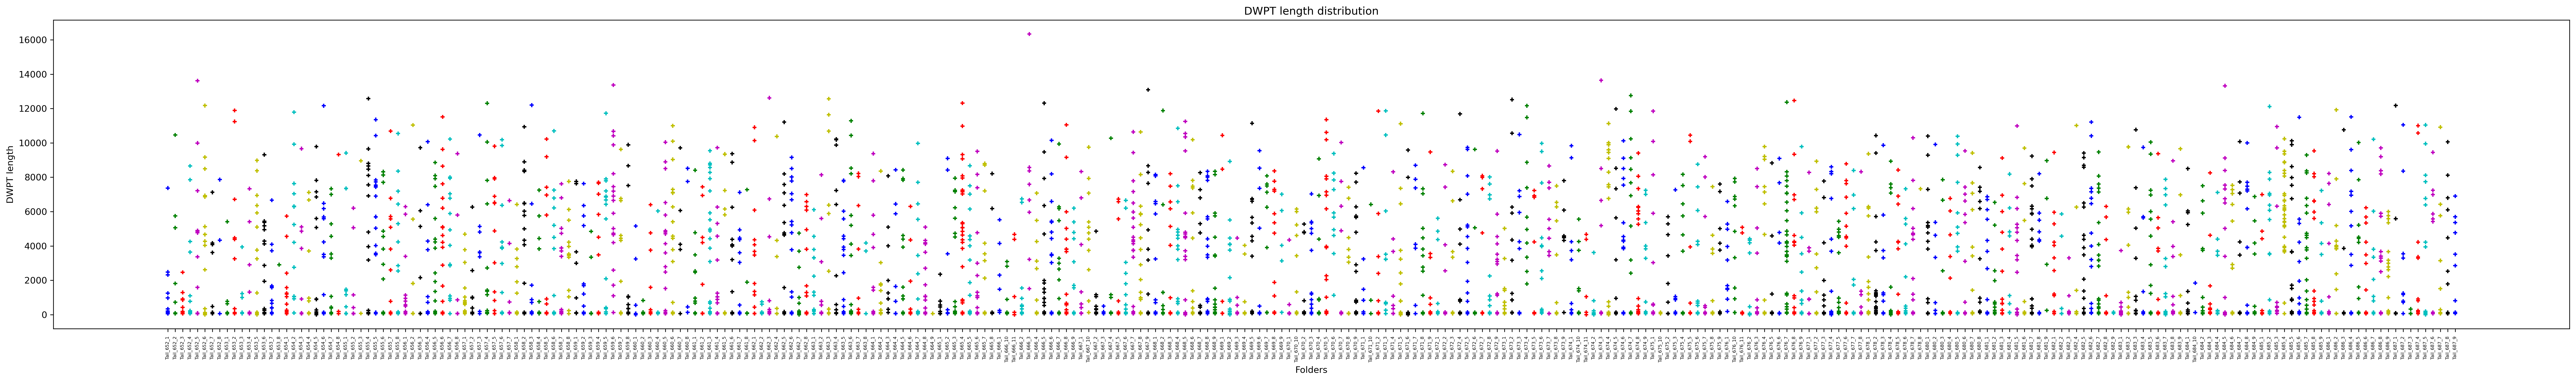

In [39]:
# DWPT 航程长度分布散点可视化
plt.figure(figsize=(40,6), dpi=300)
x_axis_folders = []
y_axis_dwpt_lengths = []
# selected_colors = np.arange(len(folder_names))
selected_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
colors = []
for iList in range(len(dwpt_lists)):
    dwpt_list = dwpt_lists[iList]
    for dwpt in dwpt_list:
        x_axis_folders.append(folder_names[iList])
        y_axis_dwpt_lengths.append(len(dwpt))
        colors.append(selected_colors[iList%len(selected_colors)])

plt.scatter(x_axis_folders, y_axis_dwpt_lengths, c=colors, marker='+', s=20, alpha=1)
plt.xticks(rotation='vertical')
plt.tick_params(axis='x', pad=5, labelsize=5)
plt.xlabel("Folders")
plt.ylabel("DWPT length")
plt.title("DWPT length distribution")
plt.tight_layout()
plt.savefig(os.path.join(dwpt_list_savepath, "DWPT_length_distribution.png"))
plt.show()

In [3]:
# 基于航程的近邻聚类
'''dwpt_lists = []
for folder_name in folder_names:
    data_folder = os.path.join(exception_data_readpath, folder_name)
    mat_names = os.listdir(data_folder)
    dwpt_list = []
    for mat_name in mat_names:
        mat_path = os.path.join(data_folder, mat_name)
        mat_data = loadmat(mat_path)
        dwpt_list.append(mat_data["DWPT"][0][0][0])
    dwpt_lists.append(dwpt_list)'''
dwpt_list_savepath = os.path.join(result_savepath, 'dwpt_list')
if os.path.exists(dwpt_list_savepath) == False:
    os.mkdir(dwpt_list_savepath)


# 读取dwpt_lists
dwpt_lists = np.load(os.path.join(dwpt_list_savepath, 'dwpt_lists.npy'), allow_pickle=True)


# dwpt_lists降维展开，生成航程长度列表
dwpt_len_list = []
dwpt_lists_flatten = []
for i, dwpt_list in enumerate(dwpt_lists):
    dwpt_len_list.append(len(dwpt_list))
    for j, dwpt in enumerate(dwpt_list):
        dwpt_list[j] = len(dwpt_list[j])
        dwpt_lists_flatten.append(dwpt_list[j])

Iteration times =  30
Cluster std 1: 144.04387004258945
Cluster std 2: 321.6505940260899
Cluster std 3: 236.12551530744415
Cluster std 4: 234.884351907699
Cluster std 5: 206.9123899291022
Cluster std 6: 280.6168203468775
Cluster std 7: 231.9735446814976
Cluster std 8: 216.37310138455305
Cluster std 9: 393.97437382260745
Cluster std 10: 52.281725555725345
Cluster std 11: 589.9172823371088
Cluster std 12: 242.94095169239063
Cluster std 13: 163.83055103905005
Cluster std 14: 224.1120824212635
Cluster std 15: 198.26020439424133
Cluster std 16: 0.0
Cluster size 1: (217,)
Cluster size 2: (116,)
Cluster size 3: (92,)
Cluster size 4: (181,)
Cluster size 5: (225,)
Cluster size 6: (170,)
Cluster size 7: (180,)
Cluster size 8: (95,)
Cluster size 9: (83,)
Cluster size 10: (1778,)
Cluster size 11: (40,)
Cluster size 12: (195,)
Cluster size 13: (215,)
Cluster size 14: (198,)
Cluster size 15: (188,)
Cluster size 16: (1,)
Cluster centers: [  633.40092166  9397.4137931   2687.04347826  5651.49171271
  

C:\Users\86108\AppData\Local\Temp\ipykernel_464\1107692747.py:52: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(cluster_labels, dwpt_lists_flatten, c=colors, s=10, cmap='viridis')


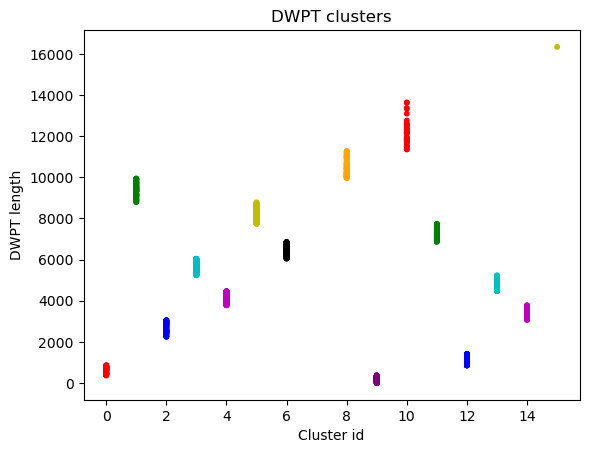

In [11]:
# K-means 聚类
def kmeans_clustering(data, K, max_iter=100):
    # 初始化聚类中心
    centers = []
    centers.append(np.random.choice(data))
    for _ in range(K-1):
        distances = np.array([min([np.linalg.norm(x-c)**2 for c in centers]) for x in data])
        prob = distances / distances.sum()
        cumulative_prob = prob.cumsum()
        r = np.random.rand()
        for j, p in enumerate(cumulative_prob):
            if r < p:
                centers.append(data[j])
                break

    iIter = 0
    for _ in range(max_iter):
        # 计算每个样本与聚类中心的距离
        distances = np.abs(data[:, np.newaxis] - centers)
        # 将样本分配到最近的簇中
        labels = np.argmin(distances, axis=1)
        # 更新聚类中心
        new_centers = np.array([np.mean(data[labels == k]) for k in range(K)])
        # 判断聚类中心是否变化
        if np.allclose(centers, new_centers):
            print("Iteration times = ", iIter)
            break
        centers = new_centers
        iIter += 1
    return labels, centers


# 聚类
K = 16
cluster_labels, cluster_centers = kmeans_clustering(np.array(dwpt_lists_flatten), K)

# # 打印聚类结果
for k in range(K):
    cluster_data = np.array(dwpt_lists_flatten)[cluster_labels == k]
    print(f"Cluster std {k+1}: {np.std(cluster_data)}")
for k in range(K):
    cluster_data = np.array(dwpt_lists_flatten)[cluster_labels == k]
    print(f"Cluster size {k+1}: {cluster_data.shape}")

# 打印聚类中心
print("Cluster centers:", cluster_centers)

# 可视化
selected_colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple']
colors = [selected_colors[i%len(selected_colors)] for i in cluster_labels]
plt.figure()
plt.scatter(cluster_labels, dwpt_lists_flatten, c=colors, s=10, cmap='viridis')
plt.xlabel("Cluster id")
plt.ylabel("DWPT length")
plt.title("DWPT clusters")
plt.savefig(os.path.join(dwpt_list_savepath, "DWPT_clusters.png"))
plt.show()

In [12]:
# 重新组织文件结构
K = 16
cluster_savepath = os.path.join(result_savepath, "clusters")
if not os.path.exists(cluster_savepath):
    os.mkdir(cluster_savepath)

for k in range(K):
    cluster_k_savepath = os.path.join(cluster_savepath, f"cluster_{k+1}")
    if not os.path.exists(cluster_k_savepath):
        os.mkdir(cluster_k_savepath)

for i, folder_name in enumerate(folder_names):
    data_folder = os.path.join(exception_data_readpath, folder_name)
    mat_names = os.listdir(data_folder)
    for j, mat_name in enumerate(mat_names):
        mat_path = os.path.join(data_folder, mat_name)
        mat_flatten_id = sum(dwpt_len_list[:i]) + j
        cluster_id = cluster_labels[mat_flatten_id]
        cluster_k_savepath = os.path.join(cluster_savepath, f"cluster_{cluster_id+1}")
        shutil.copy(mat_path, cluster_k_savepath)

In [5]:
print(sum(dwpt_len_list[:5]))
print(dwpt_len_list)

59
[16, 8, 9, 11, 15, 17, 12, 3, 10, 10, 5, 8, 24, 17, 16, 1, 20, 13, 13, 10, 17, 16, 15, 3, 15, 11, 2, 20, 20, 17, 17, 12, 17, 7, 8, 12, 19, 20, 16, 6, 16, 9, 8, 13, 14, 13, 6, 15, 17, 13, 10, 11, 17, 12, 12, 7, 13, 5, 8, 15, 18, 11, 14, 8, 8, 10, 4, 27, 19, 5, 4, 14, 7, 27, 14, 9, 13, 19, 4, 14, 6, 10, 6, 21, 21, 15, 16, 16, 8, 14, 11, 18, 14, 13, 3, 14, 10, 9, 7, 13, 19, 17, 21, 1, 11, 8, 19, 32, 23, 17, 11, 6, 6, 8, 5, 15, 8, 9, 17, 16, 15, 19, 12, 9, 12, 13, 8, 5, 10, 14, 31, 16, 13, 16, 10, 9, 18, 18, 17, 11, 20, 25, 6, 16, 5, 6, 18, 9, 10, 16, 5, 12, 16, 11, 19, 15, 19, 10, 14, 11, 19, 7, 3, 10, 10, 9, 14, 12, 7, 16, 11, 10, 8, 7, 11, 18, 5, 8, 12, 14, 11, 11, 10, 11, 6, 16, 11, 12, 7, 15, 12, 5, 6, 14, 29, 19, 15, 17, 25, 15, 11, 2, 10, 8, 12, 7, 14, 16, 11, 13, 10, 13, 11, 9, 10, 12, 10, 8, 29, 16, 13, 10, 12, 15, 13, 16, 19, 9, 8, 14, 25, 10, 15, 13, 18, 15, 1, 15, 9, 12, 13, 13, 16, 11, 12, 13, 17, 14, 8, 17, 14, 21, 11, 4, 12, 6, 10, 8, 19, 16, 27, 11, 4, 11, 12, 14, 13, 22

In [18]:
# 对每个聚类计算WSHR的方差
cluster_savepath = os.path.join(result_savepath, "clusters")
WSHR_cluster_savepath = os.path.join(result_savepath, "WSHR_cluster")
if not os.path.exists(WSHR_cluster_savepath):
    os.mkdir(WSHR_cluster_savepath)

WSHR_exception_idx_lists = []
for k in range(K):
    cluster_k_savepath = os.path.join(cluster_savepath, f"cluster_{k+1}")
    mat_names = os.listdir(cluster_k_savepath)
    WSHR_exception_idx_list = []
    for mat_name in mat_names:
        mat_path = os.path.join(cluster_k_savepath, mat_name)
        mat_data = loadmat(mat_path)
        WSHR_data = mat_data["WSHR"][0][0][0]
        # print(np.array(WSHR_data).reshape(-1))
        WSHR_exception_idx = np.where(np.array(WSHR_data).reshape(-1)==0)
        # print(list(WSHR_exception_idx))
        WSHR_exception_idx_list.extend(list(WSHR_exception_idx)[0].tolist())
        # print(WSHR_exception_idx_list)
    WSHR_exception_idx_lists.append(WSHR_exception_idx_list)
    print(f"Cluster {k+1} std: {np.std(WSHR_exception_idx_list)}")
np.save(os.path.join(WSHR_cluster_savepath, f"WSHR_exception_idx_lists.npy"), WSHR_exception_idx_lists)

Cluster 1 std: 180.0843887878866
Cluster 2 std: 2279.8266456257247
Cluster 3 std: 672.957294708052
Cluster 4 std: 1262.0517918125045
Cluster 5 std: 1083.6993814863238
Cluster 6 std: 2162.4106748624445
Cluster 7 std: 1517.8288683291967
Cluster 8 std: 450.6138387666642
Cluster 9 std: 3207.2743269833354
Cluster 10 std: 39.6670762360168
Cluster 11 std: 1882.1608132522508
Cluster 12 std: 2075.354642871696
Cluster 13 std: 210.04124471565797
Cluster 14 std: 1285.7921167158931
Cluster 15 std: 944.591367211778
Cluster 16 std: 0.816496580927726


d:\coding\Anaconda\Software\lib\site-packages\numpy\lib\npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [29]:
# 对各聚类文件夹中的WSHR异常值分布进行卡方检验
WSHR_exception_idx_lists = np.load(os.path.join(WSHR_cluster_savepath, f"WSHR_exception_idx_lists.npy"),
                                    allow_pickle=True)

# 获取所有聚类文件夹最大WSHR数据长度
WSHR_len_lists = []
mat_max_num_list = []
for k in range(K):
    WSHR_len_list = []
    cluster_k_savepath = os.path.join(cluster_savepath, f"cluster_{k+1}")
    mat_names = os.listdir(cluster_k_savepath)
    for mat_name in mat_names:
        mat_data = loadmat(os.path.join(cluster_k_savepath, mat_name))
        WSHR_len_list.append(len(mat_data['WSHR'][0][0][0]))
    WSHR_len_lists.append(WSHR_len_list)
    mat_max_num_list.append(np.max(WSHR_len_list))
np.save(os.path.join(WSHR_cluster_savepath, f"WSHR_len_lists.npy"), WSHR_len_lists)
np.save(os.path.join(WSHR_cluster_savepath, f"mat_max_num_list.npy"), mat_max_num_list)

K_square_test_lists = []
for k, idx_list in enumerate(WSHR_exception_idx_lists):
    K_square_test_list = [0 for i in range(len(internal_segment_quantiles)+1)]
    
    for i, idx in enumerate(idx_list):
        internal_idx = np.digitize(idx/mat_max_num_list[k], internal_segment_quantiles)
        K_square_test_list[internal_idx] += 1
    K_square_test_lists.append(K_square_test_list)
K_square_test_array = np.array(K_square_test_lists).T
print(K_square_test_array)

# 执行卡方检验
chi2, p, dof, expected = chi2_contingency(K_square_test_array)

print("卡方值:", chi2)
print("p值:", p)
print("自由度:", dof)
# print("期望频数:", expected)

d:\coding\Anaconda\Software\lib\site-packages\numpy\lib\npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


[[ 1826 31053  3103 23244 22501 30891 26737   850  9154  5582  6930 19606
   2965 25669 14859     3]
 [  401 11188  2410 12973 19437 21106 18887   147  7755   222  2888 13422
    338 19082 11410     0]
 [  111  3884  1802  5548 12107  7549  6790    83  6158    82    32  7205
    126 13065 10354     0]
 [   91  3108   100  1444  4751  6039  3249    31  4742    18    49  5959
     35  4963  3820     0]]
卡方值: 36016.55052515351
p值: 0.0
自由度: 45


In [26]:
print(WSHR_exception_idx_lists[15])

[0, 1, 2]


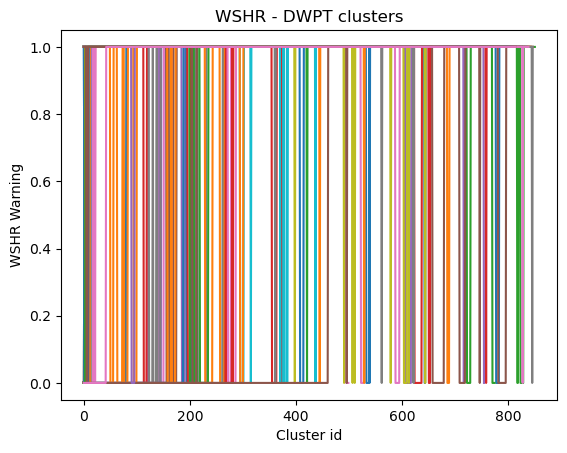

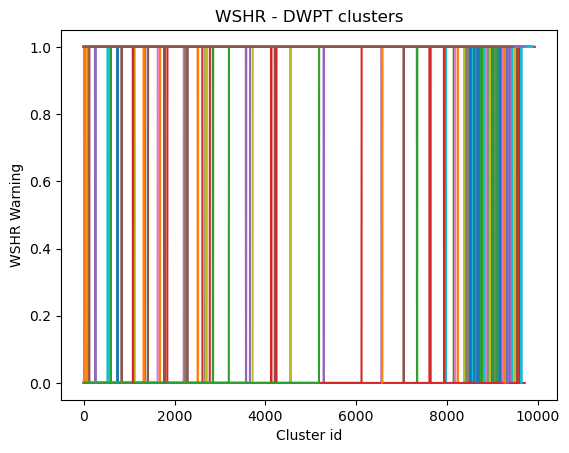

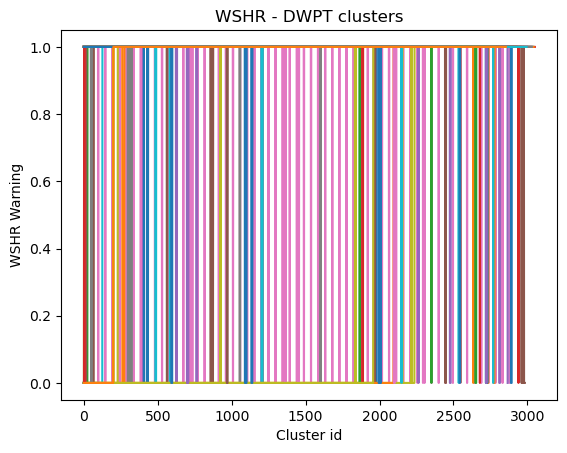

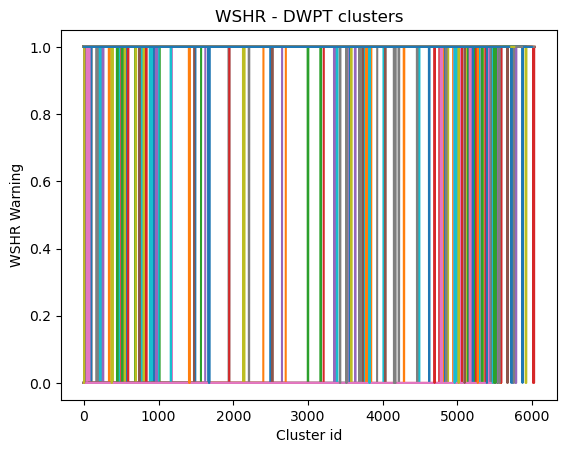

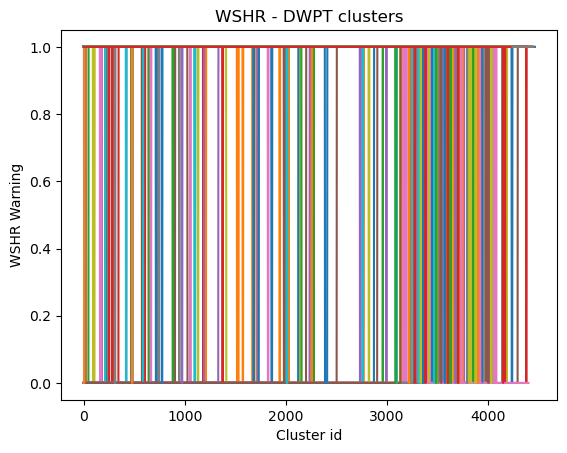

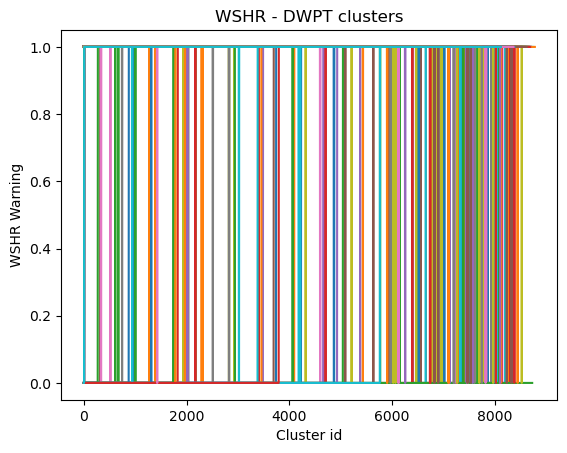

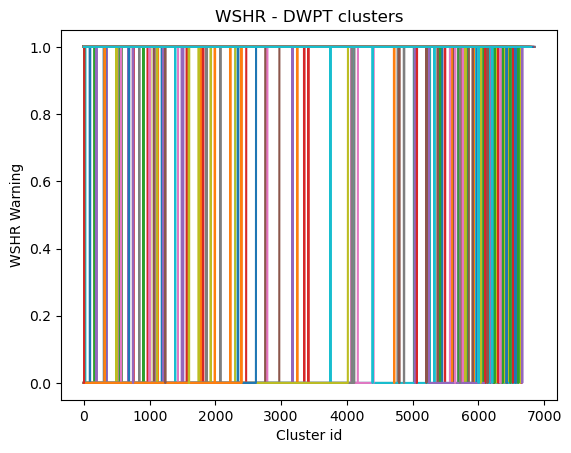

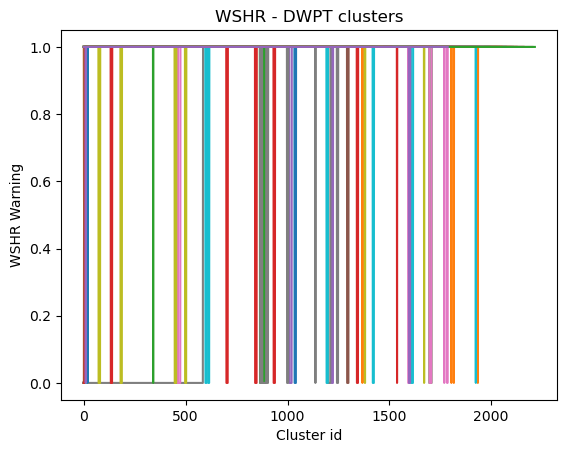

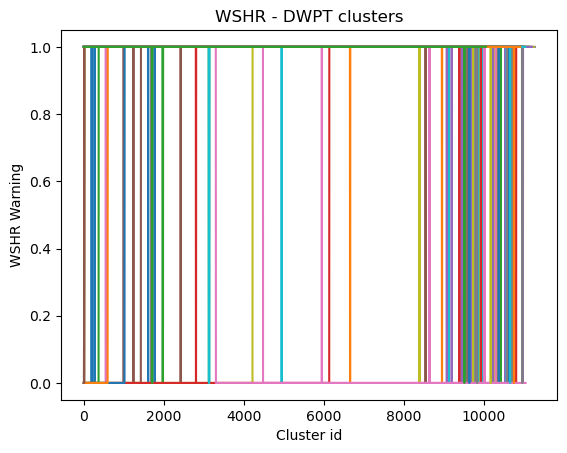

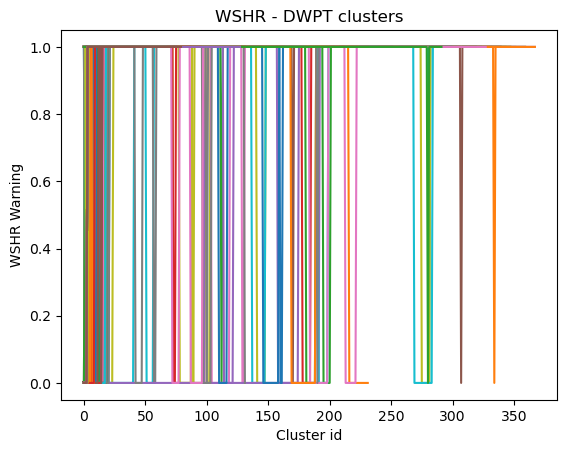

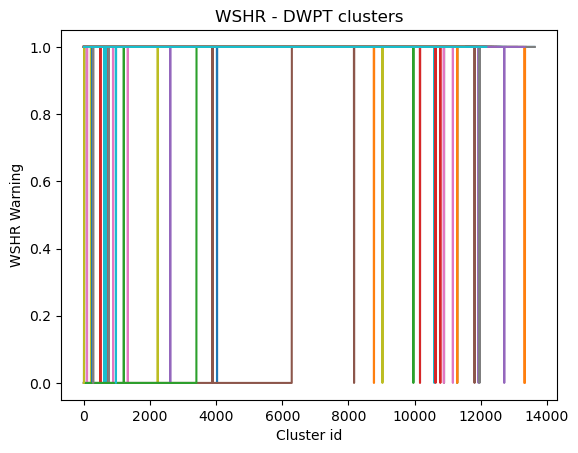

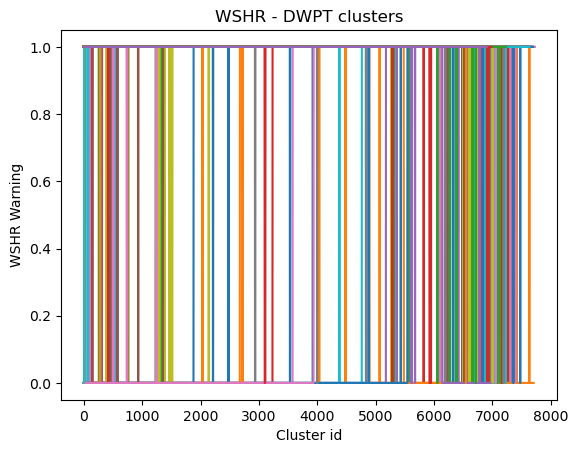

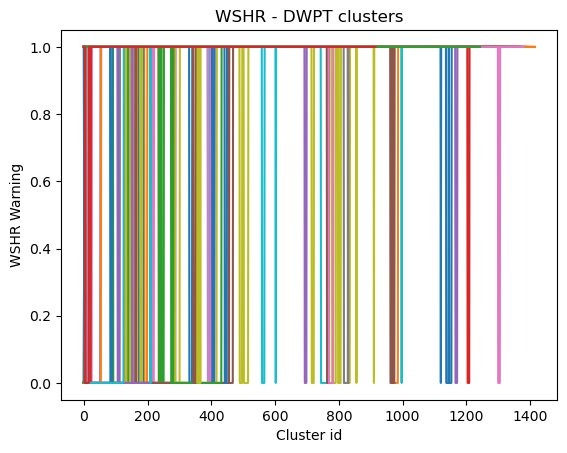

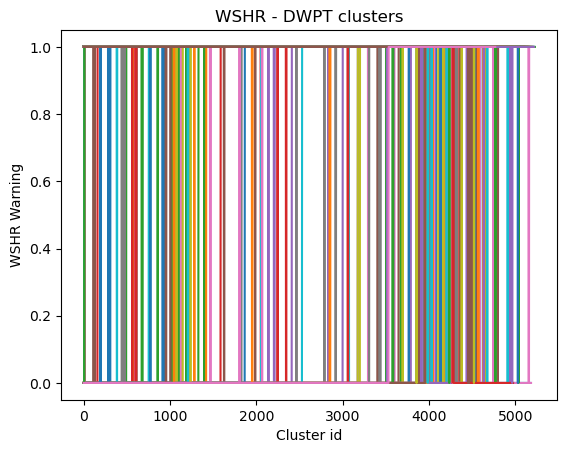

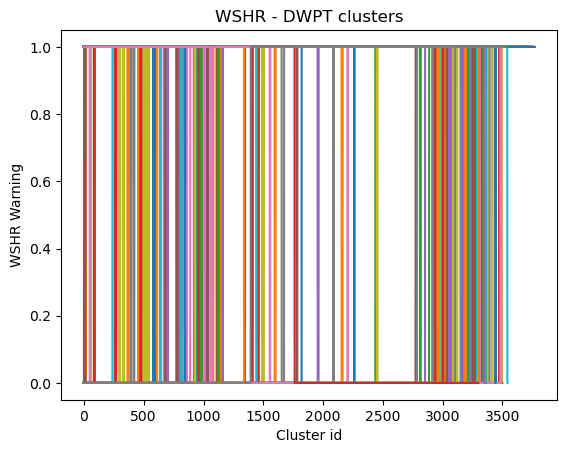

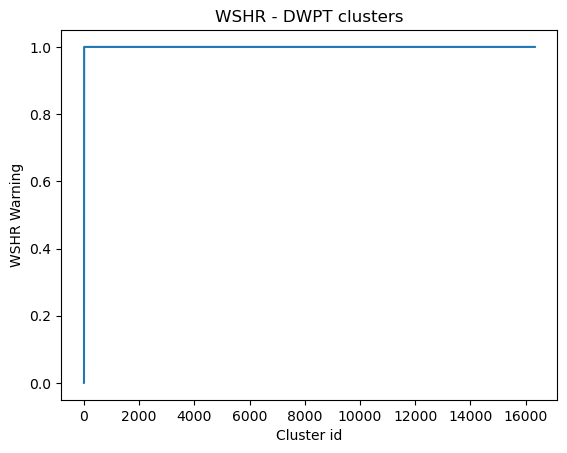

In [13]:
# 对每个聚类打印WSHR的折线图
cluster_savepath = os.path.join(result_savepath, "clusters")
WSHR_cluster_savepath = os.path.join(result_savepath, "WSHR_cluster")
if not os.path.exists(WSHR_cluster_savepath):
    os.mkdir(WSHR_cluster_savepath)

for k in range(K):
    cluster_k_savepath = os.path.join(cluster_savepath, f"cluster_{k+1}")
    mat_names = os.listdir(cluster_k_savepath)
    plt.figure()
    for mat_name in mat_names:
        mat_path = os.path.join(cluster_k_savepath, mat_name)
        mat_data = loadmat(mat_path)
        WSHR_data = mat_data["WSHR"][0][0][0]
        WSHR_data = np.array(WSHR_data).reshape(-1)
        # print(WSHR_data)
        plt.plot(WSHR_data)
    plt.xlabel("Cluster id")
    plt.ylabel("WSHR Warning")
    plt.title("WSHR - DWPT clusters")
    plt.savefig(os.path.join(WSHR_cluster_savepath, "WSHR_clusters_%d.png"%k))
    plt.show()

In [ ]:
# Greenwich时间可视化
K = 16
cluster_savepath = os.path.join(result_savepath, "clusters")
GMT_cluster_savepath = os.path.join(result_savepath, "GMT_cluster")
if not os.path.exists(GMT_cluster_savepath):
    os.mkdir(GMT_cluster_savepath)

for k in range(K):
    GMT_cluster_k_savepath = os.path.join(GMT_cluster_savepath, f"cluster_{k+1}")
    if not os.path.exists(GMT_cluster_k_savepath):
        os.mkdir(GMT_cluster_k_savepath)
    cluster_k_savepath = os.path.join(cluster_savepath, f"cluster_{k+1}")
    mat_names = os.listdir(cluster_k_savepath)
    for j, mat_name in enumerate(mat_names):
        plt.figure()
        mat_path = os.path.join(cluster_k_savepath, mat_name)
        mat_data = loadmat(mat_path)
        # print(mat_data.keys())
        GMT_HOUR_data = mat_data["GMT_HOUR"][0][0][0]
        GMT_MINUTE_data = mat_data["GMT_MINUTE"][0][0][0]
        GMT_SEC_data = mat_data["GMT_SEC"][0][0][0]
        plt.plot(GMT_HOUR_data)
        plt.plot(GMT_MINUTE_data)
        plt.plot(GMT_SEC_data)
        plt.xlabel("Cluster id")
        plt.ylabel("GMT data")
        plt.title("GMT - DWPT clusters")
        plt.savefig(os.path.join(GMT_cluster_k_savepath, "GMT_clusters_%d_%d.png"%(k,j)))
        # plt.show()